# **Introduction à l'apprentissage automatique**

Pour l'apprentissage supervisé, par convention, nous utilisons deux matrices, soient $X$ et $y$. 

$X$, contient les caractéristiques (*features*) et est de taille $n \times p$, où $n$ est le nombre d'exemples (observations) et $p$ est le nombre de caractéristiques (dimensionnalité).

$$X = \begin{bmatrix} 
f_{11} & f_{12} & \ldots & f_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
f_{n1} & f_{12} & \ldots & f_{np} \\
\end{bmatrix}
$$ 



$y$, est en fait un vecteur qui contient les étiquettes associées à chaque exemple. Il est donc de taille $n$. 


$$
y = \begin{bmatrix} 
e_1 \\
e_2 \\
\vdots \\ 
e_n
\end{bmatrix}$$

$X$ et $y$ doivent toujours être ordonnés de la même façon, i.e. pour un index $i$, les données de $X_i$ correspondent à l'étiquette $y_i$.



Comme nous entrainons des modèles sur un ensemble d'entrainement (`train`) et testons leurs performances sur un ensemble de test (`test`), nous dénotons ces ensembles comme $X_\text{train}$ et $X_\text{test}$ et $Y_\text{train}$ et $Y_\text{test}$.

## Installation et chargement des librairies nécessaires

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  
Voici une description de certaines des librairies utilisées.
- `missingo` permet de visualiser rapidement les données manquantes
- `sklearn`  scikit-learn est un incontournable pour faire de l'apprentissage automatique
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)

Nous allons utiliser la librairie <code>scikit-learn</code> dans ce projet. La <a href='https://scikit-learn.org/stable/index.html'>documentation de scikit-learn</a> est très complète. 

Nous suivons toujours la même recette pour préparer les donnés et entrainer les différents modèles.
```python
# Division en ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Transformation
scaler = StandardScaler().set_output(transform="pandas")
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Pour chaque modèle à tester - Entrainement et Évaluation
regressor = Regressor()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
score = regressor.score(X_test, y_test)
```

In [92]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


La fonction <code>make_pipeline</code> permet d'intégrer toutes ces étapes pour plusieurs modèles très facilement.

Un pipeline applique séquentiellement différentes opérations.  Dans les pipelines de `scikit-learn`, nous retrouvons 2 concepts importants:

* les transformateurs (transformer) qui offrent les fonctions `fit` et `transform`
* les estimateurs (estimators) qui offrent les fonctions`fit` et `predict`

Par exemple : 
```python
X_train, X_test, y_train, y_test = train_test_split(X, y)

pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Étape 1: Traitement/Transformation
    ('regressor', LogisticRegression())  # Étape 2: Entrainement d'un ou plusieurs modèles
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
accuracy = pipeline.score(X_test, y_test)
```

In [3]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math


import missingno
import statsmodels.api as sm

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, BaggingRegressor,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.datasets import make_regression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, f1_score, mean_absolute_error,
                            confusion_matrix, classification_report, roc_auc_score, recall_score)


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # IVADO palette

%matplotlib inline

## Chargement des données


Le jeu de données que nous allons utiliser contient les données de rendement d'avoine collectées entre 2004 et 2022 nettoyées ainsi que des données météorologiques pour un nombre de régions de l'Ontario.

Nous voulons prédire le rendement d'avoine.  La tâche relève donc de l'apprentissage supervisé et est une tâche de régression.  

Nous voulons prédire un nombre et non une catégorie (étiquette).

In [19]:
df = pd.read_csv('dataset_v1.csv', index_col=0)
df.head()

De quoi a l'air la distribution de la variable cible à prédire ?

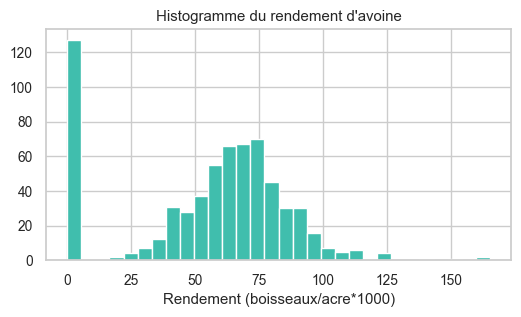

In [21]:
_ = plt.figure(figsize=(6,3))
df.Rendement.hist(bins=30, color=colors[0])
plt.title("Histogramme du rendement d'avoine")
plt.xlabel("Rendement (boisseaux/acre*1000)")
plt.show()

In [77]:
plt.subplot(1,1,2)
plt.scatter(df.Annee, df.Rendement )
plt.subplot(1,2,2)
plt.scatter(df.TOTAL_PRECIPITATION, df.Rendement)

ValueError: num must be an integer with 1 <= num <= 1, not 2

<Figure size 640x480 with 0 Axes>

Y a-t-il des valeurs manquantes ? 

Certains algorithmes d'apprentissage automatique ne supportent pas les valeurs manquantes.  Nous devons donc les imputer ou les éliminer.  Lorsque nous avons un petit nombre d'exemples, nous voulons souvent en conserver le maximum de données, donc l'élimination n'est pas une option envisageable.

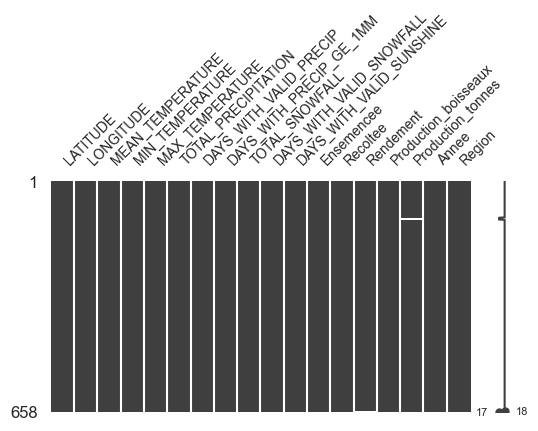

In [22]:
# Visualisons les valeurs manquantes
missingno.matrix(df, figsize=(6,3), fontsize=10)
plt.show()

Nous avons quelques valeurs de NaN pour la production de boisseaux en tonnes et pour le rendement.

Le graphique de `missingo` ne représente que les NaN.  Qu'en est-il du rendement égal à  0 ?

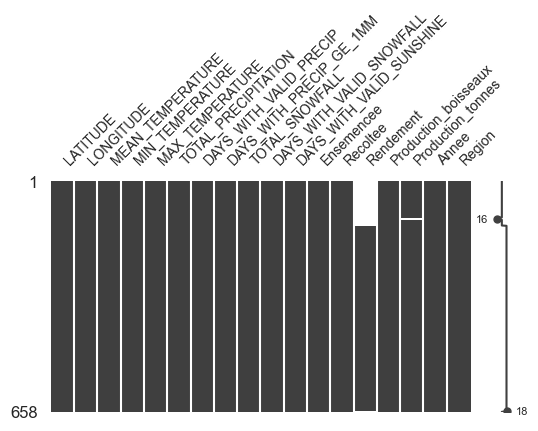

In [23]:
mx = df.copy()
mx.loc[mx.Rendement==0, 'Rendement'] = np.nan
missingno.matrix(mx, figsize=(6,3), fontsize=10)
plt.show()

Est-ce qu'une valeur de 0 lorsque nous avons une valeur de Production (boisseaux et tonnes) est un vrai 0?

In [24]:
df.loc[(df.Rendement == 0) & (df.Production_boisseaux != 0), :]

,LATITUDE,LONGITUDE,MEAN_TEMPERATURE,MIN_TEMPERATURE,MAX_TEMPERATURE,TOTAL_PRECIPITATION,DAYS_WITH_VALID_PRECIP,DAYS_WITH_PRECIP_GE_1MM,TOTAL_SNOWFALL,DAYS_WITH_VALID_SNOWFALL,DAYS_WITH_VALID_SUNSHINE,Ensemencee,Recoltee,Rendement,Production_boisseaux,Production_tonnes,Annee,Region
0,45.054,-76.784,9.797829,-24.0,32.5,901.4,352.0,120.0,168.8,352.0,0.0,27.592198,23.281722,0.0,0.796741,0.016182,2021,Frontenac
0,44.403,-76.908,10.057898,-23.5,34.0,815.9,360.0,111.0,115.8,360.0,0.0,1122.657562,947.275062,0.0,38.955752,0.791191,2021,Lennox And Addington


Nous n'avons que deux cas où le rendement est 0 et la production de boisseaux n'est pas 0. Est-ce une erreur?

Comme nous voulons prédire le rendement, nous ne garderons que les exemples qui ont une valeur de rendement supérieure à 0.

In [25]:
df = df.loc[df.Rendement > 0, :].reset_index()
df = df.iloc[:,1:]

In [40]:
# Nombre de données manquantes par variable
# Conditions : Le nb de na est 0 et il n'y a pas d'autre valeur nulle
df.isna().sum(0)==0 & df.notnull().any()

LATITUDE                    True
LONGITUDE                   True
MEAN_TEMPERATURE            True
MIN_TEMPERATURE             True
MAX_TEMPERATURE             True
TOTAL_PRECIPITATION         True
DAYS_WITH_VALID_PRECIP      True
DAYS_WITH_PRECIP_GE_1MM     True
TOTAL_SNOWFALL              True
DAYS_WITH_VALID_SNOWFALL    True
DAYS_WITH_VALID_SUNSHINE    True
Ensemencee                  True
Recoltee                    True
Rendement                   True
Production_boisseaux        True
Production_tonnes           True
Annee                       True
Region                      True
dtype: bool

Nous n'avons pas de valeurs manquantes dans notre jeu de données.

## Imputation des valeurs manquantes

S'il y avait eu des données manquantes, il aurait fallu faire bien attention pour ne pas introduire de biais et pour ne pas créer une fuite de données (*data leakage*). 

C'est pourquoi nous séparons nos données en ensemble d'entrainement et de test <b>avant</b> de faire l'imputation.  Le choix de la méthode d'imputation devient un paramètre à ajuster. 


Quelle methode d'imputation choisir ?

La <a href='https://scikit-learn.org/stable/modules/impute.html'>documentation de scikit-learn</a> est très complète. Il existe d'autres méthodes qui peuvent être utilisées.

Il faut faire attention pour ne pas introduire de biais. Les données peuvent être manquantes par hasard ou elles peuvent être manquantes pour des raisons bien particulières.

### Création de la matrice X et du vecteur 

In [12]:
df.columns

Index(['LATITUDE', 'LONGITUDE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE',
       'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'DAYS_WITH_VALID_PRECIP',
       'DAYS_WITH_PRECIP_GE_1MM', 'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_SNOWFALL',
       'DAYS_WITH_VALID_SUNSHINE', 'Ensemencee', 'Recoltee', 'Rendement',
       'Production_boisseaux', 'Production_tonnes', 'Annee', 'Region'],
      dtype='object')

In [42]:
cols = ['DAYS_WITH_VALID_SUNSHINE','DAYS_WITH_VALID_PRECIP', 
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','DAYS_WITH_PRECIP_GE_1MM','TOTAL_SNOWFALL', 
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'Annee', 'LATITUDE', 'LONGITUDE']

X = df.loc[:, cols]  # Caractéristiques (température, precipitation, etc.)
y = df.Rendement  # Valeurs cibles (rendement) (target)

### Création des ensembles d'entrainement et de test

Rappel :  L'ensemble de test doit être mis de côté et on ne doit pas y toucher avant l'évaluation finale de notre modèle. 


In [43]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Corrélation entre les variables


Il est important d'évaluer la corrélation entre les variables.  Les algorithmes d'apprentissage ne se comportent pas tous de la même façon.  Certains performent mieux avec des données gaussiennes, d'autres sont très sensibles aux valeurs numériques et une transformation est nécessaire, d'autres sont sensibles aux variables corrélées entre elles.

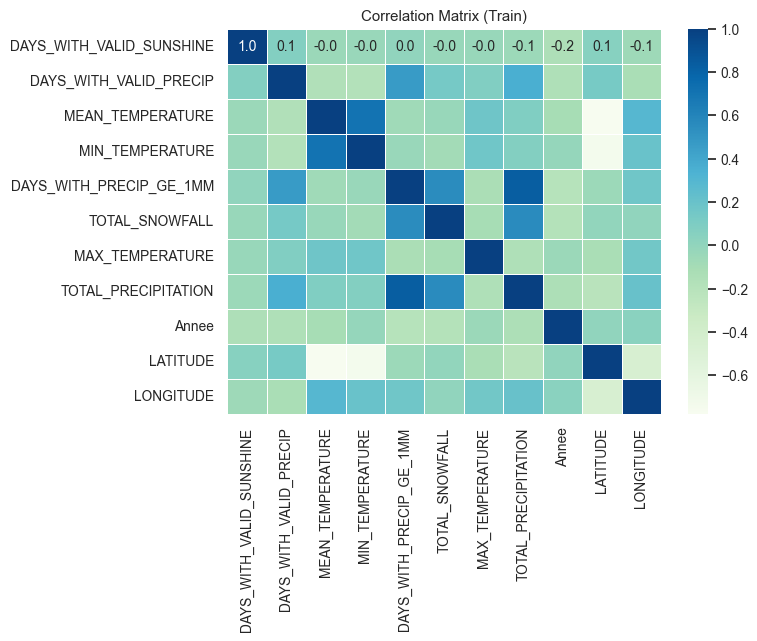

In [44]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

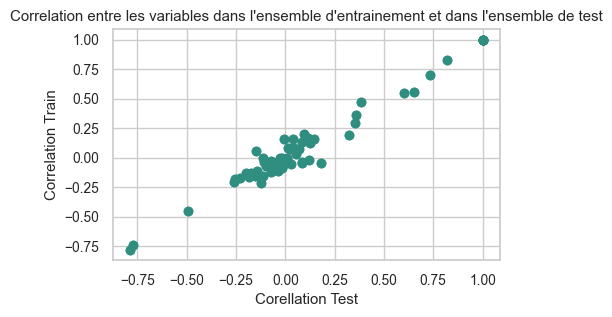

In [45]:
plt.figure(figsize=(5,3))
plt.scatter(X_test.corr(), X_train.corr(), color=colors[2])
plt.ylabel('Correlation Train')
plt.xlabel('Corellation Test')
plt.title ("Correlation entre les variables dans l'ensemble d'entrainement et dans l'ensemble de test")
plt.show()

## Transformation (normalisation, standardisation, encodage)

Des transformations sont parfois nécessaires tout dépendant des distributions des variables.  
Nous voudrons par exemple utiliser un encodage One-Hot pour les variables qualitatives (catégories) ou ramener les valeurs entre 0 et 1 pour les variables qui ne sont pas du même ordre de grandeur.

Ici, nous transformerons toutes les variables en z-score en utilisant la classe `StandardScaler`.

https://scikit-learn.org/stable/modules/preprocessing.html

In [46]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Prédire le rendement d'avoine

La prédiction du rendement d'avoine est une tâche de régression.  Nous voulons prédire un nombre.

Nous pourrons évaluer la performance des modèles sur nos données regardant:
* le coefficient de détermination ($R^2$)
* la $MSE$ (*mean squared error*).



Il existe différents algorithmes d'apprentissage automatique dans scikit-learn.  Tous les modèles ont leurs particuliarités. Il est nécessaire d'entrainer plusieurs modèles et de les comparer.  Pour un même modèle, un choix de paramètres différents peut mener à des résultats différents.  Il est nécessaire d'optimiser les paramètres.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    
<img src="https://scikit-learn.org/stable/_static/ml_map.png" width='1200px'/>

Nous testerons ici la forêt d'arbres aléatoires et la régression linéaire.  Ce sont deux algorithmes qui sont utilisées couramment.

Le `DummyRegressor` peut servir pour le prototypage de notre code.  Il utilise des règles très simples et expose les mêmes fonctions que les autres classes de `Regressor`.

In [48]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train_scaled, y_train)
y_pred = dummy_regressor.predict(X_test_scaled)
y_train_pred = dummy_regressor.predict(X_train_scaled)
score = dummy_regressor.score(X_test_scaled, y_test)

In [49]:
def plot_pred_vs_true(y_test, y_pred, score, model_name, y_train=None, y_train_pred=None):
    plt.figure(figsize=(4,3))
    if y_train is not None and y_train_pred is not None:
        plt.scatter(y_train, y_train_pred, label='Training data', color=colors[1])
        
    plt.scatter(y_test, y_pred, label='Test data', color=colors[0])
    plt.title('{} [test score={:.2f}]'.format(model_name, score))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.ylim(y_test.min(), y_test.max())
    plt.show()

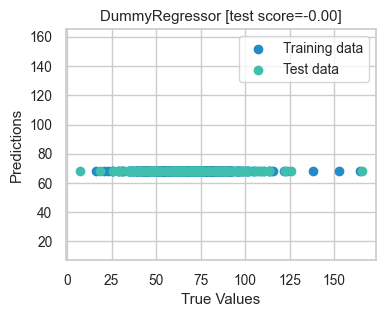

In [50]:
plot_pred_vs_true(y_test, y_pred, score, 'DummyRegressor', y_train=y_train, y_train_pred=y_train_pred)

### Forêt d'arbres aléatoire

Utilisons maintenant un `Regressor` plus pertinent, soit une forêt alétaoire (*random forest*) 

La forêt de d'arbres décision aléatoire est une méthode d'ensemble qui peut être utilisée pour les problèmes de régression et de classification  Cet algorithme non linéaire combine les prédictions de plusieurs arbres de décision.  Chaque arbre de décision de la forêt est entrainé en utilisant des caractéristiques et des exemples choisis au hasard. 

<img src='https://www.spotfire.com/content/dam/spotfire/images/graphics/inforgraphics/random-forest-diagram.svg' width='450px'>

<a style='font-size:10px;' href='https://www.spotfire.com/glossary/what-is-a-random-forest'>https://www.spotfire.com/glossary/what-is-a-random-forest</a>

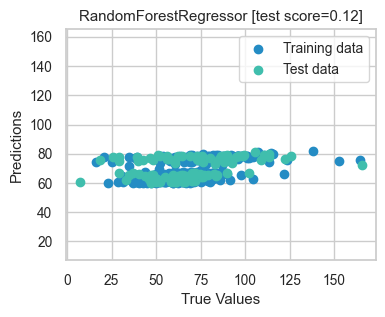

In [51]:
forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
forest_regressor.fit(X_train_scaled, y_train)
y_pred = forest_regressor.predict(X_test_scaled)
y_train_pred = forest_regressor.predict(X_train_scaled)
score = forest_regressor.score(X_test_scaled, y_test)
plot_pred_vs_true(y_test, y_pred, score, 'RandomForestRegressor', y_train=y_train, y_train_pred=y_train_pred)

In [52]:
# Calcul du MSE : nous comparons la prédiction à la vraie valeur
mse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(y_pred)*100:3.3}%)')

Mean error: 23.0 (32.8%)


Le résultat du modèle n'est pas très bon. Nous pouvons tout de même 
regarder quelles variables ont contribué le plus à la prédiction du rendement en récupérant l'`importance` (contribution au modèle) de chacune des caractéristiques.

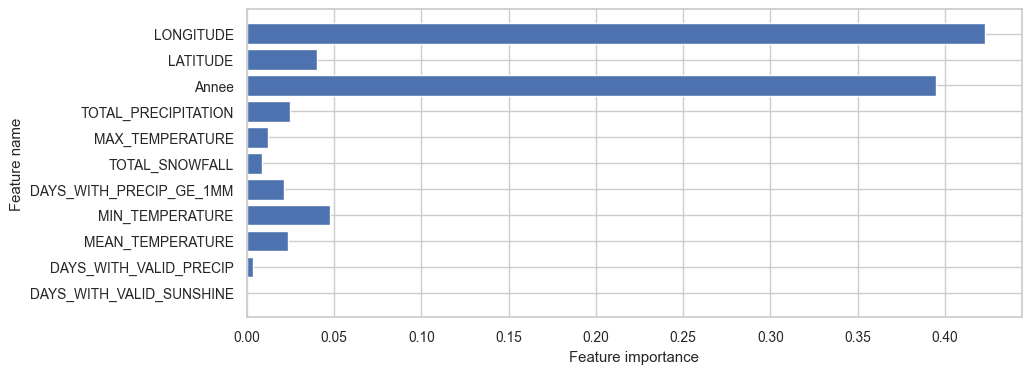

In [53]:
plt.figure(figsize=(10,4))
c_features = len(X_train_scaled.columns)
plt.barh(range(c_features), forest_regressor.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train_scaled.columns)
plt.show()

Nous pouvons voir que l'année et la longitude sont les deux variables qui ont le plus contribué.

### Régression linéaire

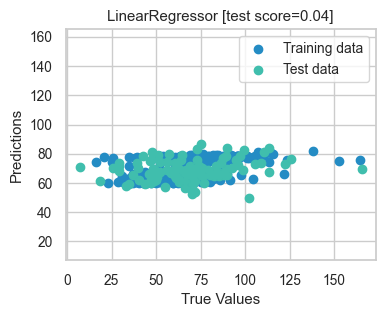

In [54]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
test_score = linear_regressor.score(X_test_scaled, y_test)
train_score = linear_regressor.score(X_train_scaled, y_train)
y_pred = linear_regressor.predict(X_test_scaled)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)

In [68]:
print(f'Intercept:  {linear_regressor.intercept_}')
pd.DataFrame(zip(X_train.columns, linear_regressor.coef_) , columns=['Nom', 'Coefficient'])

Intercept:  68.31915116691103


,Nom,Coefficient
0,DAYS_WITH_VALID_SUNSHINE,-0.115671
1,DAYS_WITH_VALID_PRECIP,0.381478
2,MEAN_TEMPERATURE,-0.589254
3,MIN_TEMPERATURE,1.732919
4,DAYS_WITH_PRECIP_GE_1MM,6.773812
5,TOTAL_SNOWFALL,-0.800642
6,MAX_TEMPERATURE,-2.197084
7,TOTAL_PRECIPITATION,-6.740195
8,Annee,4.537330
9,LATITUDE,-2.455931


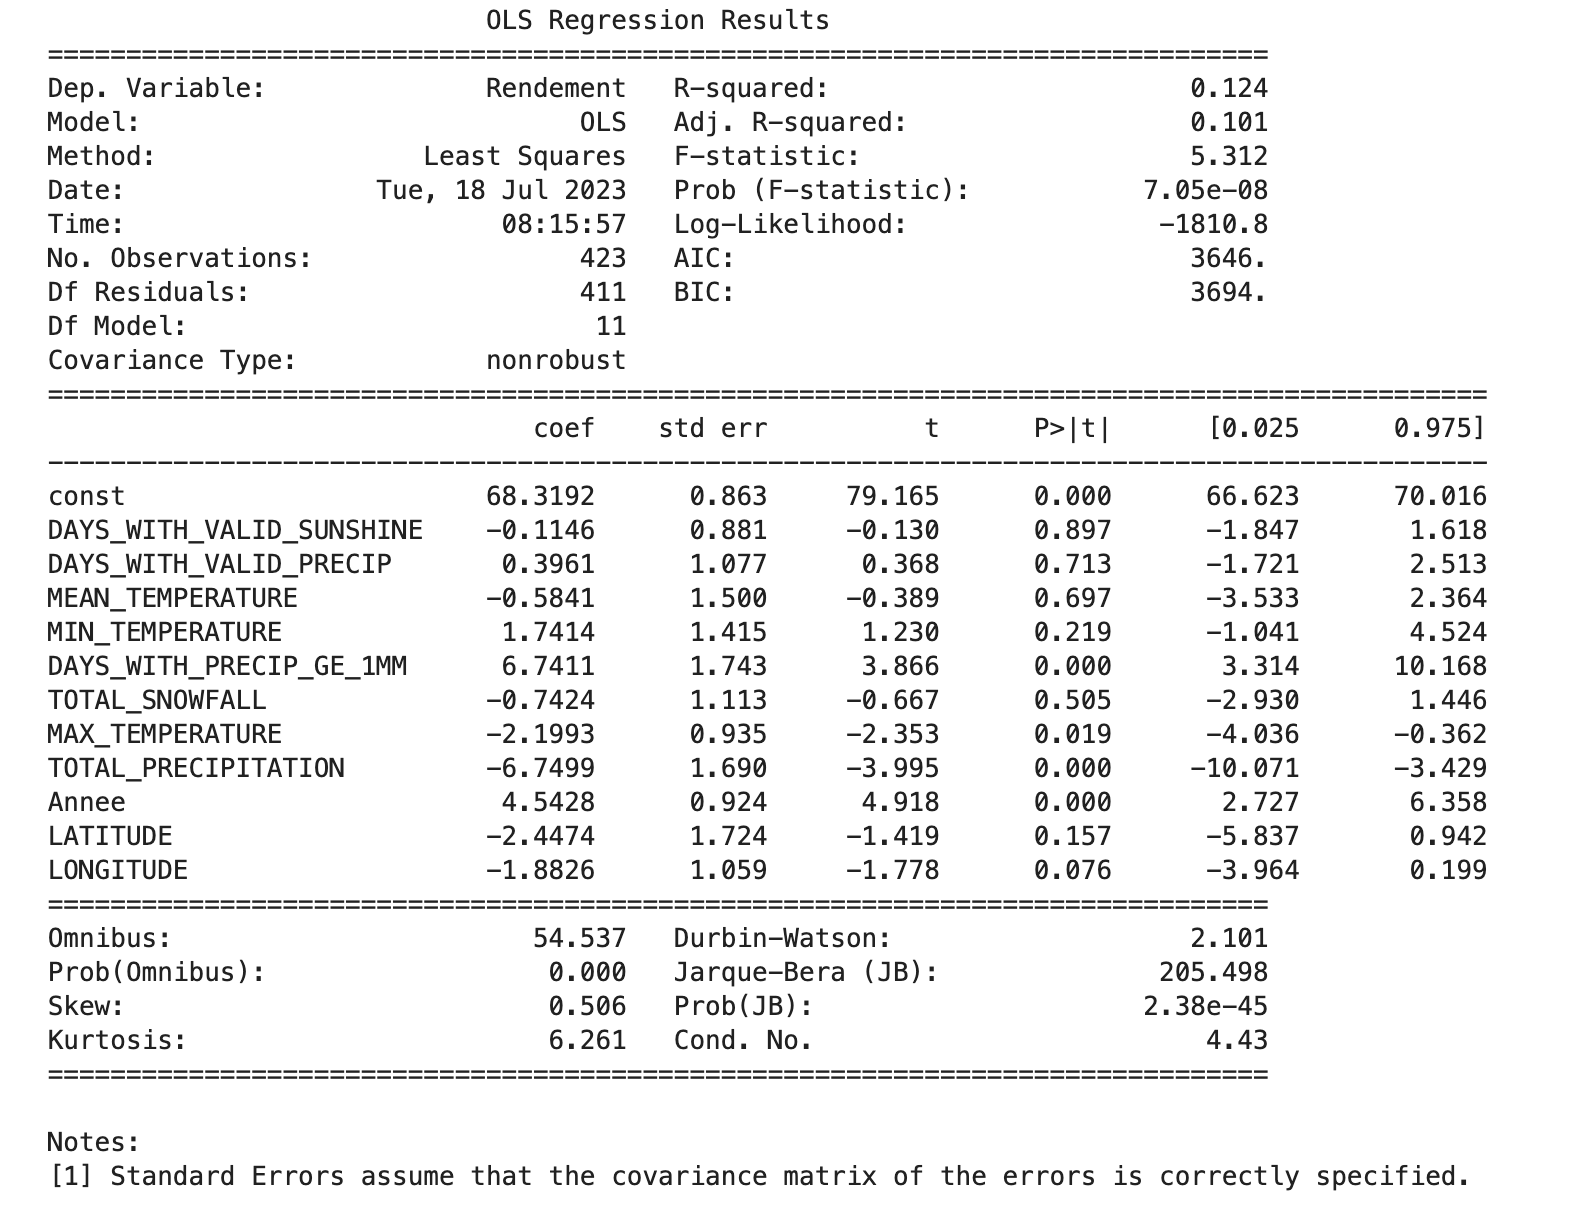


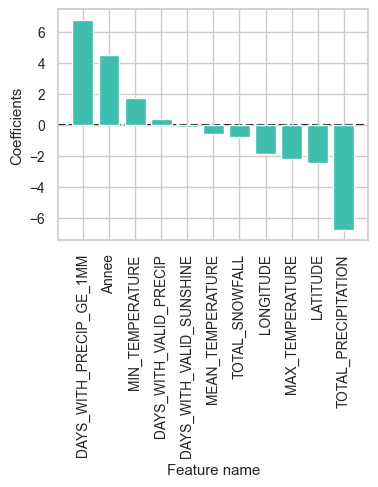

In [95]:
coefficients = pd.DataFrame(list(zip(X_train.columns, linear_regressor.coef_)), 
                            columns=['features', 'coefficients'])
coefficients.sort_values(by='coefficients', ascending=False, inplace=True)
plt.figure(figsize=(4,3))
plt.bar(range(len(coefficients)), coefficients.coefficients, color=colors[0])
plt.ylabel("Coefficients")
plt.xlabel("Feature name")
plt.xticks(np.arange(len(coefficients)), coefficients.features, rotation=90)
plt.axhline(y=0, color='black', linestyle='--', zorder=-1000)
plt.show()

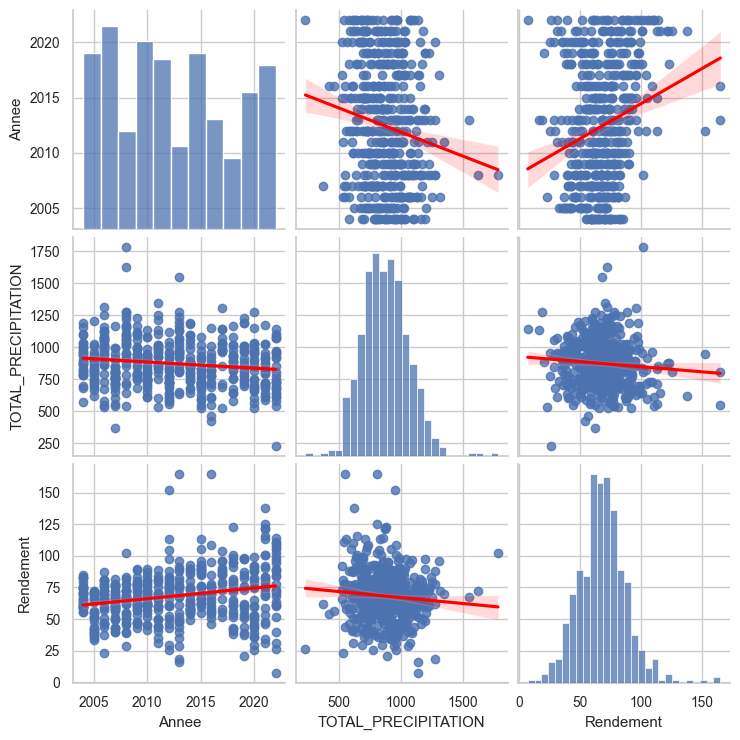

In [94]:
sns.pairplot(df.loc[:,['Annee', 'TOTAL_PRECIPITATION', 'Rendement']],
             kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

### À votre tour 

Que pouvez-vous conclure jusqu'à présent ? 

## Pipelines de Scikit Learn 
Les pipelines de scikit-learn aide dans l'organisation des projets tout en favorisant la reproductibilité.   L'application d'algorithmes d'apprentissage de façon automatique est aussi facilitée.

La fonction `make_pipeline` gère l'enchainement des différentes étapes de pré-traitement et d'entrainement.

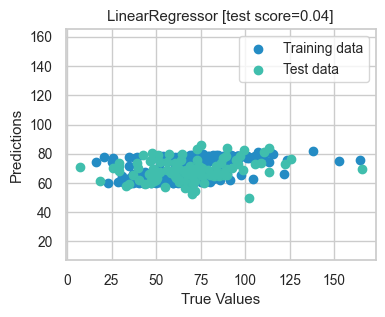

In [43]:
pipeline = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression(fit_intercept=True))
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
test_score = pipeline.score(X_test, y_test)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)

La classe `Pipeline` gère aussi l'enchainement séquentiel des différentes étapes.  Ici, nous avons besoin de nommer les étapes.  Avec `make_pipeline`, les noms sont créés automatiquement.

Nous pouvons passer l'objet `pipeline` à la méthode `cross_val_score` pour effectuer une validation croisée. 

In [44]:
results = []
estimator_names = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR']
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer(max_iter=10, random_state=0)),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    results.append([estimator, np.mean(scores), np.std(scores), 'Rendement'])
    
results = pd.DataFrame(results, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,-0.025155,0.254621,Rendement
1,RandomForestRegressor,0.076682,0.255655,Rendement
2,DecisionTreeRegressor,-0.618450,0.509389,Rendement
3,KNeighborsRegressor,0.080810,0.209428,Rendement
4,GradientBoostingRegressor,-0.002032,0.298017,Rendement
5,SVR,0.027502,0.127506,Rendement


Un coefficient de détermination négatif indique que quelque chose ne fonctionne pas.  Cela indique que le modèle de régression n'est pas capable de capturer la variation des données et qu'il effectue des prédictions moins précices qu'en utilisant simplement la moyenne.  

Quoi faire ?

* S'assurer que le code est correct 
* Vérifier les données tant les variables prédictives que la variable à prédire
* Retourner aux données pour comprendre le problème

Comme nous n'obtenons pas de très bons résultats, nous pouvons tester notre code avec des données sythétiques en utilisant la fonction `make_regression`.

In [45]:
X_tmp, y_tmp = make_regression(n_samples=X.shape[0], n_features=X.shape[1])

results_tmp = []
for estimator in estimator_names:
    pipeline = make_pipeline(IterativeImputer(), StandardScaler(), eval(estimator)())
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_tmp, y_tmp, cv=cv, n_jobs=-1)
    results_tmp.append([estimator, np.mean(scores), np.std(scores), 'scikit-learn'])

results_tmp = pd.DataFrame(results_tmp, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results_tmp

,Model,Mean Score,Std Score,Dataset
0,LinearRegression,1.000000,0.000000,scikit-learn
1,RandomForestRegressor,0.758285,0.028166,scikit-learn
2,DecisionTreeRegressor,0.250376,0.164193,scikit-learn
3,KNeighborsRegressor,0.714990,0.025463,scikit-learn
4,GradientBoostingRegressor,0.876901,0.012038,scikit-learn
5,SVR,0.113971,0.023979,scikit-learn


### À votre tour 

Que concluez-vous de ces résultats ?

## Trouver les bons paramètres et le bon modèle

Chaque algorithme d'apprentissage a ses particularités et certains modèles sont plus appropriés pour certains types de données et problèmes.  

En tenant compte de nos contraintes pratiques, nous voulons tester différents algorithmes sur les données traitées de différentes façons.  Nous voulons aussi optimiser les hyperparamètres des algorithmes testés.  

Cela fait beaucoup de combinaisons possibles.  Les `pipeline`de `scikit-learn` favorisent la traçabilité, la reproductibilité et l'automatisation.


In [97]:
estimator_names = ['LinearRegression', 'RandomForestRegressor',  'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR', 'DummyRegressor']

estimator_params = {'RandomForestRegressor': {'estimator__max_depth': [4, 6, 8, 10, 12]}}

res = []
for estimator in estimator_names:  
    pipeline = Pipeline([('imputer', None),('scaler', None), ('estimator', eval(estimator)())])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()]}
   
    parameters.update(estimator_params.get(estimator, {}))
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="r2")  
    grid_search.fit(X_train, y_train) 
    cv_results = grid_search.cv_results_
    best_estimator = grid_search.best_estimator_     
    res.append([estimator, grid_search.best_score_, grid_search.best_params_, cv_results, best_estimator]) 

In [98]:
res = pd.DataFrame(res, columns=['Model', 'Best_Score', 'Best_parameters', 'CV_Results', 'Best_estimator'])
#res.to_csv('prediction_rendement_20230707.csv')

Regardons les résultats obtenus

In [48]:
res

,Model,Best_Score,Best_parameters,CV_Results,Best_estimator
0,LinearRegression,0.045383,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.0071505546569824215, 0.00...","(SimpleImputer(), StandardScaler(), LinearRegr..."
1,RandomForestRegressor,0.175642,"{'estimator__max_depth': 10, 'imputer': Simple...","{'mean_fit_time': [0.2437221050262451, 0.18204...","(SimpleImputer(), MinMaxScaler(), (DecisionTre..."
2,KNeighborsRegressor,0.174483,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.004006767272949218, 0.003...","(SimpleImputer(), StandardScaler(), KNeighbors..."
3,GradientBoostingRegressor,0.087930,"{'imputer': IterativeImputer(), 'scaler': Robu...","{'mean_fit_time': [0.11000380516052247, 0.1119...","(IterativeImputer(), RobustScaler(), ([Decisio..."
4,SVR,0.074964,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.009173202514648437, 0.008...","(SimpleImputer(), StandardScaler(), SVR())"
5,DummyRegressor,-0.005849,"{'imputer': SimpleImputer(), 'scaler': Standar...","{'mean_fit_time': [0.0034556865692138674, 0.00...","(SimpleImputer(), StandardScaler(), DummyRegre..."


In [107]:
item = res.iloc[1,:]
item

Model                                          RandomForestRegressor
Best_Score                                                  0.178758
Best_parameters    {'estimator__max_depth': 6, 'imputer': SimpleI...
CV_Results         {'mean_fit_time': [0.15431575775146483, 0.2387...
Best_estimator     (SimpleImputer(), MinMaxScaler(), (DecisionTre...
Name: 1, dtype: object

In [108]:
item[2]

{'estimator__max_depth': 6,
 'imputer': SimpleImputer(),
 'scaler': MinMaxScaler()}

### Calcul de différentes métriques pour les meilleurs modèles choisis.

In [50]:
metric_names = [ "mean_absolute_error", 'mean_squared_error', "r2_score"] # même nom que dans la librairie

mymetrics = []
for row in res.to_dict('records'):
    model = row['Model']
    estimator = row['Best_estimator']
    pred_test = estimator.fit(X_train, y_train).predict(X_test)
    m = []
    for metric_name in metric_names:
        m.append(eval(f'{metric_name}(y_test, pred_test)'))
    mymetrics.append([model] + m)
mymetrics =  pd.DataFrame(mymetrics, columns=['Model'] + metric_names)

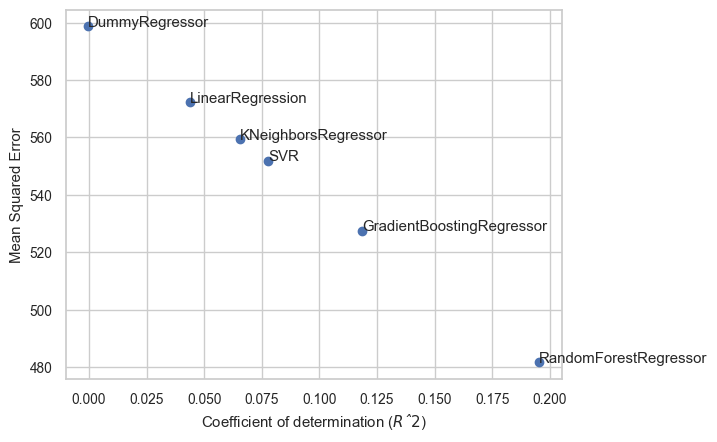

In [51]:
plt.scatter(mymetrics.r2_score, mymetrics.mean_squared_error)
for i in range(mymetrics.shape[0]):
    plt.text(mymetrics.r2_score[i], mymetrics.mean_squared_error[i], s=mymetrics.Model[i])
plt.ylabel('Mean Squared Error')
plt.xlabel('Coefficient of determination ($Rˆ2$)')
plt.show()

Voici un article s'intéressant à la prédiction du rendement: <br>
    https://www.frontiersin.org/articles/10.3389/fpls.2019.00621/full

Et un rapport produit dans le cadre d'une compétition:<br>
https://github.com/WizzX7/Morgan-Stanley-Quant-Challange/blob/main/quant_documentation.pdf
